<a href="https://colab.research.google.com/github/a4ankan/Amazon-Apparel-Recommendation-Engine/blob/master/Creating_Image_classification_API_with_TensorFlow_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stage 1: Install dependencies and setting up GPU environment

In [1]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   130k      0 --:--:-- --:--:-- --:--:--  130k
OK


In [2]:
!apt-get update & apt-get install tensorflow-model-server

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:12 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Reading package lists... Done
Building dependency tree  

In [3]:
!pip install tensorflow-gpu==1.13.1

In [4]:
!pip install requests

## Stage 2: Import project dependencies

In [5]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

'1.13.1'

## Stage 3: Dataset preprocessing

### Loading the dataset

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Image normalization

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [0]:
#X_train

In [0]:
#X_train = X_train*2

In [11]:
X_train

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

In [12]:
X_train.shape

(50000, 32, 32, 3)

## Stage 4: Defining the model

NOTE: We are using the model from the Section for Convolutional neural networks

In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


### Compiling the model

In [0]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

### Training the model

In [15]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=100)

Epoch 1/100
50000/50000 [==============================] - 6s 114us/sample - loss: 1.4880 - sparse_categorical_accuracy: 0.4604
Epoch 2/100
50000/50000 [==============================] - 4s 83us/sample - loss: 1.0287 - sparse_categorical_accuracy: 0.6373
Epoch 3/100
50000/50000 [==============================] - 4s 83us/sample - loss: 0.8484 - sparse_categorical_accuracy: 0.7037
Epoch 4/100
50000/50000 [==============================] - 4s 83us/sample - loss: 0.7233 - sparse_categorical_accuracy: 0.7489
Epoch 5/100
50000/50000 [==============================] - 4s 83us/sample - loss: 0.6165 - sparse_categorical_accuracy: 0.7849
Epoch 6/100
50000/50000 [==============================] - 4s 82us/sample - loss: 0.5421 - sparse_categorical_accuracy: 0.8107
Epoch 7/100
50000/50000 [==============================] - 4s 83us/sample - loss: 0.4646 - sparse_categorical_accuracy: 0.8376
Epoch 8/100
50000/50000 [==============================] - 4s 84us/sample - loss: 0.3914 - sparse_categorical_

KeyboardInterrupt: ignored

### Model evaluation

In [0]:
X_Test = X_test*255

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 104us/sample - loss: 2.5932 - sparse_categorical_accuracy: 0.7304


In [17]:
print("Test accuracy is {}".format(test_accuracy))

Test accuracy is 0.730400025844574


## Stage 5: Saving the model for production

### Creating the directory for the model

In [0]:
MODEL_DIR = "model/"
version = 1

In [19]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [0]:
if os.path.isdir(export_path):
    !rm -r {export_path}

### Saving the model for the TensorFlow Serving

In [21]:
tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/1/saved_model.pb


## Stage 6: Setting up the production environment

### Exporting the MODEL_DIR to environment variables

In [0]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

In [23]:
os.environ['MODEL_DIR']

'/content/model'

### Running the TensorFlow Serving REST API

In [24]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [25]:
!tail server.log

2020-01-03 18:20:47.517396: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2020-01-03 18:20:47.520451: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-01-03 18:20:47.539616: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2020-01-03 18:20:47.580355: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 66519 microseconds.
2020-01-03 18:20:47.581437: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /content/model/1/assets.extra/tf_serving_warmup_requests
2020-01-03 18:20:47.581521: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: cifar10 version: 1}
2020-01-03 18:20:47.582769: I tensorflow_serving/

## Stage 7: Creating the first POST request

In [39]:
random_image = np.random.randint(0, len(X_test))
random_image

4023

### Creating the JSON data object

In [0]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [28]:
data

'{"signature_name": "serving_default", "instances": [[[[0.07058823529411765, 0.054901960784313725, 0.07450980392156863], [0.09411764705882353, 0.08235294117647059, 0.09803921568627451], [0.09411764705882353, 0.08627450980392157, 0.09803921568627451], [0.09019607843137255, 0.0784313725490196, 0.0784313725490196], [0.1843137254901961, 0.16862745098039217, 0.14901960784313725], [0.3215686274509804, 0.3137254901960784, 0.3058823529411765], [0.47843137254901963, 0.4549019607843137, 0.43137254901960786], [0.5176470588235295, 0.4980392156862745, 0.47058823529411764], [0.45098039215686275, 0.43529411764705883, 0.396078431372549], [0.6745098039215687, 0.6274509803921569, 0.5254901960784314], [0.8156862745098039, 0.7647058823529411, 0.6352941176470588], [0.8352941176470589, 0.7254901960784313, 0.6313725490196078], [0.8352941176470589, 0.6666666666666666, 0.6196078431372549], [0.8509803921568627, 0.7019607843137254, 0.6549019607843137], [0.8196078431372549, 0.6313725490196078, 0.5764705882352941]

### Sending the first POST request to the model

In [0]:
headers = {"content-type":"application/json"}

In [0]:
!unzip 'Flask-API.zip'

In [0]:
json_response = requests.post(url="http://localhost:8501/v1/models/cifar10:predict", data=data, headers=headers)

In [31]:
json_response

<Response [200]>

In [0]:
predictions = json.loads(json_response.text)['predictions']

In [33]:
predictions

[[7.588827e-20,
  8.70252708e-27,
  1.13026552e-07,
  0.00059137732,
  1.75474422e-17,
  0.999408484,
  1.87863284e-11,
  1.36786318e-10,
  3.73971337e-27,
  2.99875e-19]]

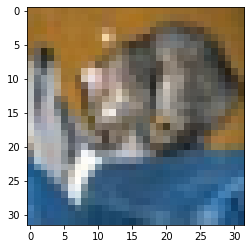

In [48]:
plt.imshow(X_test[0])

In [47]:
class_names[np.argmax(predictions[0])]

'dog'

## Stage 8: Sending the POST request to a specific model

In [0]:
specific_json_response = requests.post(url="http://localhost:8501/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [44]:
specific_json_response

<Response [200]>